# NIDS CSV Analysis Code
This notebook performs full data loading, feature engineering, automatic labeling, model training, and evaluation.

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [ ]:
# 1. Load the CSV data
CSV_PATH = 'assessment3.csv'  # adjust path if necessary
df = pd.read_csv(CSV_PATH, on_bad_lines='skip')
print(f"Loaded rows and columns: {df.shape}")


Loaded rows and columns: (237229, 7)


In [ ]:
# 2. Parse Info into DstPort and Flags
def parse_info(info):
    m = re.match(r"(\d+)\s*>\s*(\d+)\s*\[([A-Z,]+)\]", str(info))
    if not m:
        # Return np.nan for DstPort when no match
        return pd.Series({'DstPort': np.nan, 'Flags': []})
    try:
        # Convert to int and handle potential errors
        dst_port = int(m.group(2))
    except ValueError:
        # Return np.nan if conversion to int fails
        dst_port = np.nan

    return pd.Series({
        'DstPort': dst_port,
        'Flags': m.group(3).split(',')
    })

parsed = df['Info'].apply(parse_info)

# Assign the parsed columns directly back to df
# This avoids potential issues with concat creating non-Series like structures
df['DstPort'] = parsed['DstPort']
df['Flags'] = parsed['Flags']


# Explicitly convert DstPort to a numeric type, coercing errors to NaN
# This helps ensure the column is in a consistent, 1-dimensional format
df['DstPort'] = pd.to_numeric(df['DstPort'], errors='coerce')

print("=== Parsed Info Sample ===")
print(df[['Info','DstPort','Flags']].head(10))

=== Parsed Info Sample ===
                                             Info  DstPort  Flags
0           1994  >  80 [SYN] Seq=0 Win=512 Len=0     80.0  [SYN]
1           1995  >  80 [SYN] Seq=0 Win=512 Len=0     80.0  [SYN]
2           1996  >  80 [SYN] Seq=0 Win=512 Len=0     80.0  [SYN]
3           1997  >  80 [SYN] Seq=0 Win=512 Len=0     80.0  [SYN]
4           1998  >  80 [SYN] Seq=0 Win=512 Len=0     80.0  [SYN]
5           1999  >  80 [SYN] Seq=0 Win=512 Len=0     80.0  [SYN]
6           2000  >  80 [SYN] Seq=0 Win=512 Len=0     80.0  [SYN]
7           2001  >  80 [SYN] Seq=0 Win=512 Len=0     80.0  [SYN]
8  80  >  2001 [RST, ACK] Seq=1 Ack=1 Win=0 Len=0      NaN     []
9           2002  >  80 [SYN] Seq=0 Win=512 Len=0     80.0  [SYN]


In [ ]:
# 3. Create a per-second window
df['Window'] = df['Time'].astype(int)


In [ ]:
# 4. Aggregate flow features
group_cols = ['Source', 'Destination', 'DstPort', 'Window']
# Ensure DstPort column is clean before grouping
features = df.dropna(subset=['DstPort']).groupby(group_cols).agg(
    PktCount=('No.', 'count'),
    AvgLen=('Length', 'mean'),
    SynCount=('Flags', lambda flags: sum('SYN' in f for f in flags))
).reset_index()

Threshold (95th percentile): 1.0
Label distribution:
 label
0    217430
1        38
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of SynCount per Flow')

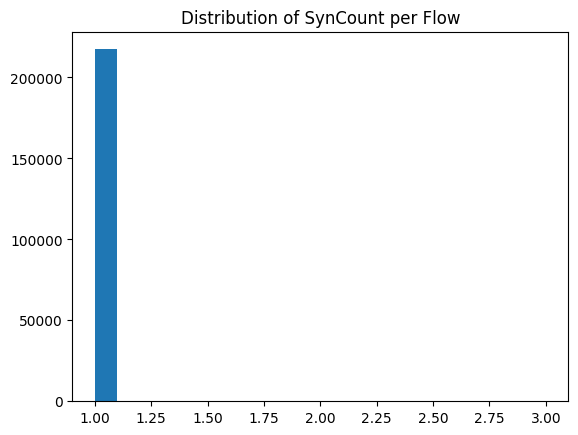

In [ ]:
# 5. Automatic labeling using 95th percentile of SynCount
threshold = features['SynCount'].quantile(0.95)
features['label'] = (features['SynCount'] > threshold).astype(int)
print(f"Threshold (95th percentile): {threshold}")
print("Label distribution:\n", features['label'].value_counts())
plt.hist(features["SynCount"], bins=20)
plt.title("Distribution of SynCount per Flow")



In [ ]:
# 6. Balance classes by undersampling
df_attack = features[features['label'] == 1]
df_normal = features[features['label'] == 0]
df_normal_down = resample(df_normal, replace=False, n_samples=len(df_attack), random_state=42)
df_balanced = pd.concat([df_attack, df_normal_down])

X = df_balanced[['PktCount', 'AvgLen', 'SynCount']]
y = df_balanced['label']


In [ ]:
# 7. Split and scale
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

print(f"Training labels distribution: {np.unique(y_train, return_counts=True)}")
print(f"Testing labels distribution:  {np.unique(y_test, return_counts=True)}")


Training labels distribution: (array([0, 1]), array([26, 27]))
Testing labels distribution:  (array([0, 1]), array([12, 11]))


In [ ]:

# 8. Train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_s, y_train)
y_pred = model.predict(X_test_s)
y_proba = model.predict_proba(X_test_s)[:,1]



In [ ]:
# 9. Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        11

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23

ROC AUC Score: 1.0000


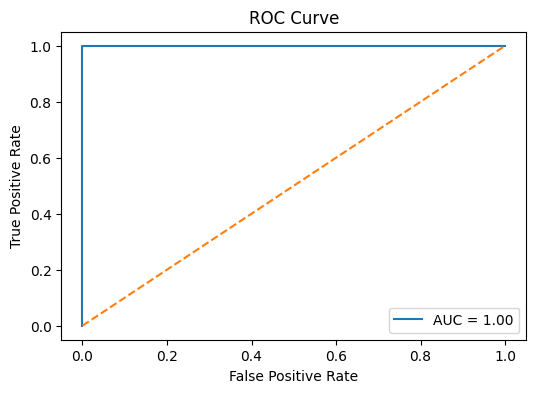

In [ ]:
# 10. Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()